In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import make_column_selector
from imblearn.pipeline import Pipeline

***Hasil histogram star***

Kolom tersedia:
 Index(['title', 'url', 'stars', 'name', 'reviewUrl', 'text'], dtype='object')


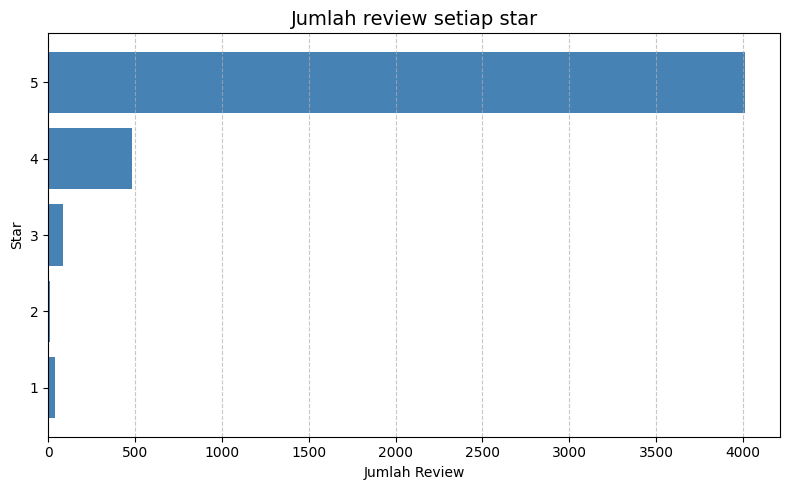

Jumlah review tiap star:
stars
1      42
2      13
3      87
4     485
5    4012
Name: count, dtype: int64


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# ===========================================================
# 📂 Load Dataset (Coba Beberapa Separator)
# ===========================================================
url = "https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Uzbek_Shahizinda.csv"

# Coba baca otomatis separator
try:
    data = pd.read_csv(url)
except pd.errors.ParserError:
    try:
        data = pd.read_csv(url, sep=';')
    except pd.errors.ParserError:
        data = pd.read_csv(url, sep='\t')

# ===========================================================
# 🔍 Cek Kolom
# ===========================================================
print("Kolom tersedia:\n", data.columns)

# ===========================================================
# 📊 Tentukan Kolom Rating
# ===========================================================
# Cari kolom yang ada kata 'star' atau 'rating'
kolom_star = None
for c in data.columns:
    if 'star' in c.lower() or 'rating' in c.lower():
        kolom_star = c
        break

if kolom_star is None:
    raise ValueError("Kolom berisi rating/star tidak ditemukan. Cek data.columns dulu.")

# ===========================================================
# 📊 Hitung dan Visualisasi
# ===========================================================
jumlah_star = data[kolom_star].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.barh(jumlah_star.index.astype(str), jumlah_star.values, color='steelblue')
plt.title('Jumlah review setiap star', fontsize=14)
plt.xlabel('Jumlah Review')
plt.ylabel('Star')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Jumlah review tiap star:")
print(jumlah_star)

***Persentase Hanya Rating + Rating Saja***

📘 Jumlah total data: 4639
📋 Kolom tersedia: ['title', 'url', 'stars', 'name', 'reviewUrl', 'text'] 

✅ Kolom teks ulasan yang digunakan : text
✅ Kolom rating yang digunakan      : stars

📊 Statistik Review & Rating:
Total data                        : 4639
Dengan review + rating             : 2180 (46.99%)
Hanya memberi rating (tanpa review): 2459 (53.01%)



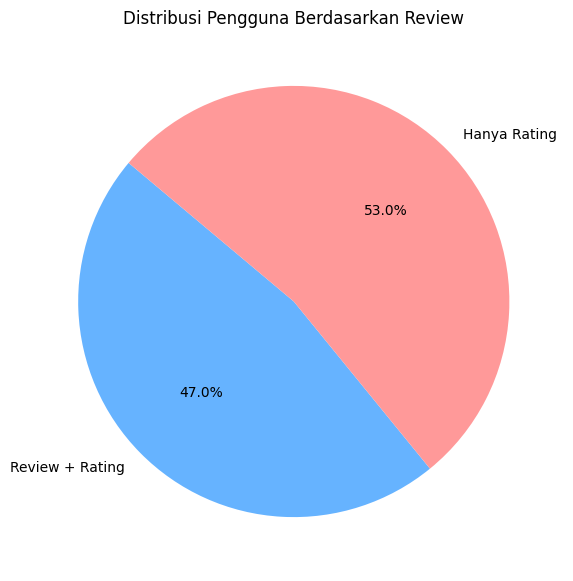

📝 Contoh data pengguna yang hanya memberi rating tanpa review:
   stars text
0      5  NaN
2      5  NaN
3      5  NaN
4      5  NaN
6      5  NaN 

📝 Contoh data pengguna yang memberi review + rating:
    stars                                               text
1       5                              A glimpse of history.
5       5  Absoluta maravilla y que vale hasta cada som d...
10      5  ..uno dei posti più belli ed emozionanti in cu...
11      5                                            A must.
12      5                     Juda ajoyib taassurotlar oldim 



In [3]:
# =====================================
# 🎯 Analisis Review & Rating (AUTO-FIX)
# =====================================

import pandas as pd
import matplotlib.pyplot as plt

# ---------------- 1️⃣ Load Dataset ----------------
url = 'https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Uzbek_Shahizinda.csv'

# Deteksi otomatis delimiter (koma atau titik koma)
with open('/tmp/shaizinda.csv', 'w', encoding='utf-8') as f:
    import requests
    f.write(requests.get(url).text)

with open('/tmp/shaizinda.csv', encoding='utf-8') as f:
    sample = f.readline()
    sep = ';' if ';' in sample else ','

# Baca dataset dengan delimiter yang benar
data = pd.read_csv('/tmp/shaizinda.csv', sep=sep, engine='python', on_bad_lines='skip')

# Bersihkan nama kolom
data.columns = data.columns.str.replace('"', '').str.strip()
print("📘 Jumlah total data:", len(data))
print("📋 Kolom tersedia:", list(data.columns), "\n")

# ---------------- 2️⃣ Deteksi Kolom ----------------
# Kolom teks
possible_text_cols = ['text', 'review', 'title']
text_col = next((col for col in possible_text_cols if col in data.columns), None)
if text_col is None:
    raise KeyError("❌ Tidak ditemukan kolom teks ulasan (text/review/title).")

# Kolom rating
possible_rating_cols = ['stars', 'rating']
rating_col = next((col for col in possible_rating_cols if col in data.columns), None)
if rating_col is None:
    raise KeyError("❌ Tidak ditemukan kolom rating (stars/rating).")

print(f"✅ Kolom teks ulasan yang digunakan : {text_col}")
print(f"✅ Kolom rating yang digunakan      : {rating_col}\n")

# ---------------- 3️⃣ Analisis Ada/Tidaknya Review ----------------
data['Ada_Review'] = data[text_col].apply(lambda x: bool(str(x).strip()) and str(x).lower() != 'nan')

total_data = len(data)
dengan_review = data['Ada_Review'].sum()
tanpa_review = total_data - dengan_review

persen_dengan = (dengan_review / total_data) * 100
persen_tanpa = (tanpa_review / total_data) * 100

print("📊 Statistik Review & Rating:")
print(f"Total data                        : {total_data}")
print(f"Dengan review + rating             : {dengan_review} ({persen_dengan:.2f}%)")
print(f"Hanya memberi rating (tanpa review): {tanpa_review} ({persen_tanpa:.2f}%)\n")

# ---------------- 4️⃣ Visualisasi Pie Chart ----------------
plt.figure(figsize=(7, 7))
plt.pie([dengan_review, tanpa_review],
        labels=['Review + Rating', 'Hanya Rating'],
        autopct='%1.1f%%', startangle=140,
        colors=['#66b3ff', '#ff9999'])
plt.title("Distribusi Pengguna Berdasarkan Review")
plt.show()

# ---------------- 5️⃣ Contoh Data ----------------
print("📝 Contoh data pengguna yang hanya memberi rating tanpa review:")
print(data.loc[~data['Ada_Review'], [rating_col, text_col]].head(5), "\n")

print("📝 Contoh data pengguna yang memberi review + rating:")
print(data.loc[data['Ada_Review'], [rating_col, text_col]].head(5), "\n")


***Pre-Processing***

In [4]:
import pandas as pd

data_csv = 'https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Uzbek_Shahizinda.csv'

data = pd.read_csv(data_csv, on_bad_lines='skip')  # lewati baris yang rusak
data.head()

,title;url;stars;name;reviewUrl;text
0,Shah-i-Zinda necropolis;https://www.google.com...
1,Shah-i-Zinda necropolis;https://www.google.com...
2,Shah-i-Zinda necropolis;https://www.google.com...
3,Shah-i-Zinda necropolis;https://www.google.com...
4,Shah-i-Zinda necropolis;https://www.google.com...


***Cleaning Data (Empty Review)***

In [5]:
# ===========================================================
# 📚 Import Library
# ===========================================================
import pandas as pd

# ===========================================================
# 📂 Membaca Dataset dengan Penanganan Otomatis
# ===========================================================
url = "https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Uzbek_Shahizinda.csv"

# Baca dataset dengan pemisah titik koma (;) dan abaikan baris rusak
df = pd.read_csv(url, sep=';', engine='python', on_bad_lines='skip')

# Bersihkan nama kolom dari spasi dan tanda kutip
df.columns = df.columns.str.strip().str.replace('"', '')

print("✅ Dataset berhasil dimuat!")
print("📘 Jumlah data:", len(df))
print("📋 Kolom tersedia:", list(df.columns), "\n")

# ===========================================================
# 🧹 Menghapus Kolom yang Tidak Diperlukan
# ===========================================================
df_cleaned = df.drop(columns=['name', 'reviewUrl', 'url', 'stars'], errors='ignore')

# ===========================================================
# 🧾 Menampilkan Hasil dalam Bentuk Tabel
# ===========================================================
print("✅ Kolom setelah dihapus:", list(df_cleaned.columns))
print("\n📊 Data hasil pembersihan:")
display(df_cleaned.head(10))


✅ Dataset berhasil dimuat!
📘 Jumlah data: 4639
📋 Kolom tersedia: ['title', 'url', 'stars', 'name', 'reviewUrl', 'text'] 

✅ Kolom setelah dihapus: ['title', 'text']

📊 Data hasil pembersihan:


,title,text
0,Shah-i-Zinda necropolis,NaN
1,Shah-i-Zinda necropolis,A glimpse of history.
2,Shah-i-Zinda necropolis,NaN
3,Shah-i-Zinda necropolis,NaN
4,Shah-i-Zinda necropolis,NaN
5,Shah-i-Zinda necropolis,Absoluta maravilla y que vale hasta cada som d...
6,Shah-i-Zinda necropolis,NaN
7,Shah-i-Zinda necropolis,NaN
8,Shah-i-Zinda necropolis,NaN
9,Shah-i-Zinda necropolis,NaN


In [6]:
# ===========================================================
# 📚 Import Library
# ===========================================================
import pandas as pd

# ===========================================================
# 📂 Membaca Dataset
# ===========================================================
url = "https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Uzbek_Shahizinda.csv"

df = pd.read_csv(url, sep=';', engine='python', on_bad_lines='skip')

# Bersihkan nama kolom
df.columns = df.columns.str.strip().str.replace('"', '')

print("📋 Kolom sebelum pemrosesan:", list(df.columns))

# ===========================================================
# ✂️ Ambil hanya kolom title dan text
# ===========================================================
df_selected = df[['title', 'text']]  # hanya ambil 2 kolom

# ===========================================================
# 🧹 Menghapus baris yang text-nya NaN
# ===========================================================
df_cleaned = df_selected.dropna(subset=['text'])

print("📘 Jumlah data setelah menghapus text NaN:", len(df_cleaned))

# ===========================================================
# 📊 Tampilkan hasil
# ===========================================================
display(df_cleaned.head(10))


📋 Kolom sebelum pemrosesan: ['title', 'url', 'stars', 'name', 'reviewUrl', 'text']
📘 Jumlah data setelah menghapus text NaN: 2180


,title,text
1,Shah-i-Zinda necropolis,A glimpse of history.
5,Shah-i-Zinda necropolis,Absoluta maravilla y que vale hasta cada som d...
10,Shah-i-Zinda necropolis,..uno dei posti più belli ed emozionanti in cu...
11,Shah-i-Zinda necropolis,A must.
12,Shah-i-Zinda necropolis,Juda ajoyib taassurotlar oldim
16,Shah-i-Zinda necropolis,Precioso conjunto funerario Timúrida de los si...
17,Shah-i-Zinda necropolis,Kompleks nekropolii tonący w błękicie misterny...
22,Shah-i-Zinda necropolis,"Şah-i Zinde, Semerkant’ın ruhunu en derinden h..."
23,Shah-i-Zinda necropolis,Wow what a place. Incredible. A masterpiece.\n...
24,Shah-i-Zinda necropolis,"Wunderbarer Ort, ein Must in Samarkand. Leid..."


***Translate Review Bhs Inggris***

In [7]:
# ===========================================================
# 📚 Install dan Import Library
# ===========================================================
!pip install googletrans==4.0.0-rc1 --quiet
!pip install tqdm --quiet

import pandas as pd
from googletrans import Translator
from tqdm import tqdm
from IPython.display import display

# ===========================================================
# 1️⃣ Baca Dataset
# ===========================================================
url = "https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Uzbek_Shahizinda.csv"
df = pd.read_csv(url, sep=';', encoding='utf-8', dtype=str)

# ===========================================================
# 2️⃣ Inisialisasi Translator
# ===========================================================
translator = Translator()

# ===========================================================
# 3️⃣ Fungsi Translate Aman
# ===========================================================
def translate_safe(text):
    try:
        if pd.isna(text) or text.strip() == "":
            return None
        return translator.translate(text, dest='en').text
    except:
        return None

# ===========================================================
# 4️⃣ Translate Kolom title & text dengan Progress Bar
# ===========================================================
tqdm.pandas()
df['title_en'] = df['title'].progress_apply(translate_safe)
if 'text' in df.columns:
    df['text_en'] = df['text'].progress_apply(translate_safe)

# ===========================================================
# 5️⃣ Hapus Baris Kosong
# ===========================================================
df_clean = df.dropna(subset=['title_en', 'text_en'])

# ===========================================================
# 6️⃣ Tampilkan Tabel Bersih
# ===========================================================
display(df_clean[['title_en', 'text_en']])

# ===========================================================
# 7️⃣ Simpan ke CSV jika diperlukan
# ===========================================================
df_clean[['title_en', 'text_en']].to_csv("kalon_mosque_reviews_en_clean.csv", index=False)
print("✅ Hasil translate tersimpan di 'shahizinda_mosque_reviews_en_clean.csv'")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.50.0 requires httpx<1.0,>=0.24.1, but you have httpx 0.13.3 which is incompatible.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.13.3 which is incompatible.
langgraph-sdk 0.3.0 requires httpx>=0.25.2, 

100%|██████████| 4639/4639 [14:00<00:00,  5.52it/s]


,title_en,text_en
1,Shah-i-Zinda necropolis,A glimpse of history.
5,Shah-i-Zinda necropolis,"Absolute wonder and worth every som of the 50,..."
10,Shah-i-Zinda necropolis,..one of the most beautiful and exciting place...
11,Shah-i-Zinda necropolis,A must.
12,Shah-i-Zinda necropolis,I received very wonderful impressions
16,Shah-i-Zinda necropolis,Beautiful Timurid funerary complex from the 14...
17,Shah-i-Zinda necropolis,The necropolis complex is immersed in the blue...
22,Shah-i-Zinda necropolis,Shah-i Zinde is one of the places where you ca...
23,Shah-i-Zinda necropolis,Wow what a place. Incredible. A masterpiece.\n...
24,Shah-i-Zinda necropolis,"Wonderful place, a must in Samarkand.Unfortuna..."


✅ Hasil translate tersimpan di 'shahizinda_mosque_reviews_en_clean.csv'


***Labelling***

In [10]:
import pandas as pd

# URL dataset
url = "https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Uzbek_Shahizinda.csv"

# Load dataset
data = pd.read_csv(url, sep=';', encoding='utf-8')

# Hapus data kosong
data = data.dropna(subset=['text', 'stars'])

# Fungsi labeling sentimen
def label_sentiment(stars):
    stars = float(stars)
    if stars >= 4:
        return 2  # Positif
    elif stars == 3:
        return 1  # Netral
    else:
        return 0  # Negatif

# Terapkan labeling
data['label'] = data['stars'].apply(label_sentiment)

# Konversi label ke kategori teks
label_map = {
    2: 'Positif',
    1: 'Netral',
    0: 'Negatif'
}
data['Sentimen'] = data['label'].map(label_map)

# ==============================
# Tabel distribusi sentimen
# ==============================

# Hitung jumlah data per sentimen
sentiment_counts = data['Sentimen'].value_counts().reset_index()
sentiment_counts.columns = ['Sentimen', 'Jumlah Data']

# Tampilkan tabel
print("Tabel Distribusi Sentimen:")
print(sentiment_counts)

# Contoh data hasil labeling
print("\nContoh data berlabel:")
print(data[['text', 'stars', 'Sentimen']].head())


Tabel Distribusi Sentimen:
  Sentimen  Jumlah Data
0  Positif         2111
1   Netral           44
2  Negatif           25

Contoh data berlabel:
                                                 text  stars Sentimen
1                               A glimpse of history.      5  Positif
5   Absoluta maravilla y que vale hasta cada som d...      5  Positif
10  ..uno dei posti più belli ed emozionanti in cu...      5  Positif
11                                            A must.      5  Positif
12                     Juda ajoyib taassurotlar oldim      5  Positif


***Persentase Sentimen***

Ringkasan Persentase Sentimen:
  Sentimen  Jumlah  Persentase (%)
0  Positif    2111           96.83
1   Netral      44            2.02
2  Negatif      25            1.15


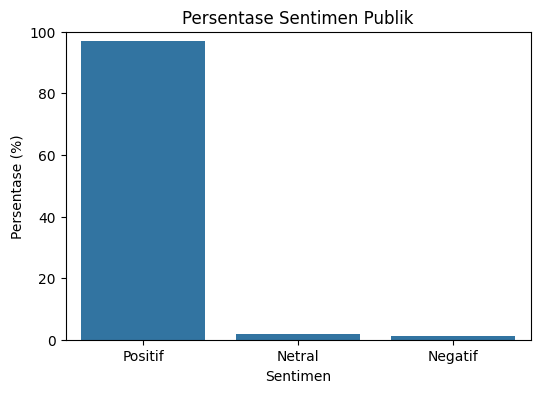

In [11]:
# ---------------- 4️⃣ Hitung Persentase Sentimen ----------------

# Hitung jumlah masing-masing sentimen
sentiment_counts = data['Sentimen'].value_counts()

# Hitung persentase
sentiment_percentages = (sentiment_counts / sentiment_counts.sum()) * 100

# Gabungkan ke dalam DataFrame ringkasan
sentiment_summary = pd.DataFrame({
    'Sentimen': sentiment_counts.index,
    'Jumlah': sentiment_counts.values,
    'Persentase (%)': sentiment_percentages.values.round(2)
})

print("Ringkasan Persentase Sentimen:")
print(sentiment_summary)

plt.figure(figsize=(6,4))
sns.barplot(
    x=sentiment_percentages.index,
    y=sentiment_percentages.values
)
plt.ylabel("Persentase (%)")
plt.xlabel("Sentimen")
plt.title("Persentase Sentimen Publik")
plt.ylim(0, 100)
plt.show()


***Model TourQual XLM-Roberta***

Jumlah total review: 2180


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu
Menganalisis dimensi TOURQUAL: 100%|██████████| 2180/2180 [2:30:01<00:00,  4.13s/it]



Tabel Distribusi Dimensi TOURQUAL:
          Dimensi  Jumlah Review
    Accessibility            100
      Environment            155
Technical Quality            281
    Human Element            382
       Experience            877
           Safety            251
      UnDimension            134


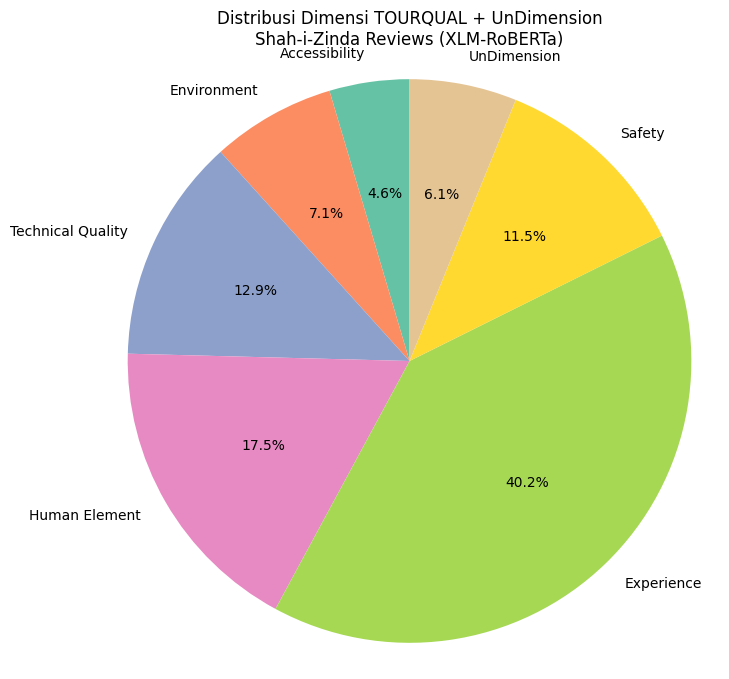

In [13]:
# ===========================================================
# 📊 Distribusi Dimensi TOURQUAL + UnDimension
# (Shah-i-Zinda Reviews | XLM-RoBERTa Zero-Shot)
# ===========================================================

!pip install transformers torch pandas seaborn matplotlib tqdm --quiet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import pipeline

# 1️⃣ Load dataset Shah-i-Zinda
url = "https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Uzbek_Shahizinda.csv"
df = pd.read_csv(url, sep=';', encoding='utf-8')

# Bersihkan kolom
df.columns = [c.strip().lower() for c in df.columns]

# Pastikan kolom teks
text_col = 'text'
df = df.dropna(subset=[text_col]).reset_index(drop=True)
df[text_col] = df[text_col].astype(str)

print("Jumlah total review:", len(df))

# 2️⃣ Definisi dimensi TOURQUAL
dimensions = [
    "Accessibility",
    "Environment",
    "Technical Quality",
    "Human Element",
    "Experience",
    "Safety"
]

candidate_labels = dimensions + ["UnDimension"]

# 3️⃣ Load XLM-RoBERTa Zero-Shot Classifier
classifier = pipeline(
    "zero-shot-classification",
    model="joeddav/xlm-roberta-large-xnli"
)

# 4️⃣ Klasifikasi dimensi
tqdm.pandas(desc="Menganalisis dimensi TOURQUAL")

def classify_dimension(text):
    result = classifier(
        text,
        candidate_labels=candidate_labels,
        hypothesis_template="This review is mainly about {}."
    )
    return result["labels"][0]

df["Dimension"] = df[text_col].progress_apply(classify_dimension)

# 5️⃣ Distribusi dimensi (TABEL)
dimension_counts = df["Dimension"].value_counts().reindex(candidate_labels, fill_value=0)

summary_table = pd.DataFrame({
    "Dimensi": dimension_counts.index,
    "Jumlah Review": dimension_counts.values
})

print("\nTabel Distribusi Dimensi TOURQUAL:")
print(summary_table.to_string(index=False))

# 6️⃣ Pie Chart
plt.figure(figsize=(8,8))
plt.pie(
    dimension_counts,
    labels=dimension_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set2", len(dimension_counts))
)
plt.title(
    "Distribusi Dimensi TOURQUAL + UnDimension\nShah-i-Zinda Reviews (XLM-RoBERTa)",
    fontsize=12
)
plt.axis("equal")
plt.show()


***Evaluasi***

=== HASIL EVALUASI MODEL – SHAH-I-ZINDA ===
Akurasi  : 1.000
Presisi  : 1.000
Recall   : 1.000
F1-Score : 1.000


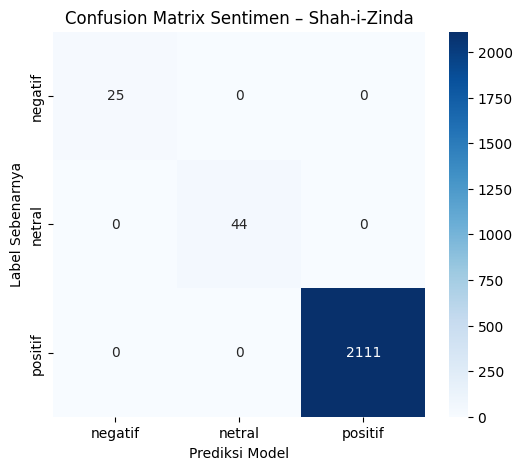

In [14]:
# ===========================================================
# 📊 Evaluasi Akurasi, Presisi, Recall, F1, Confusion Matrix
# Dataset: Shah-i-Zinda
# Ground Truth: Rating Stars
# ===========================================================

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Load dataset Shah-i-Zinda
url = "https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Uzbek_Shahizinda.csv"
df = pd.read_csv(url, sep=';', encoding='utf-8')

# Bersihkan data
df = df.dropna(subset=['text', 'stars']).reset_index(drop=True)
df['stars'] = df['stars'].astype(float)

# 2️⃣ Ground truth dari rating bintang
def true_sentiment(stars):
    if stars >= 4:
        return 'positif'
    elif stars == 3:
        return 'netral'
    else:
        return 'negatif'

df['true_label'] = df['stars'].apply(true_sentiment)

# 3️⃣ Label prediksi (contoh: rule-based / hasil model)
# Di sini contoh rule-based sebagai placeholder model
def predicted_sentiment(stars):
    if stars >= 4:
        return 'positif'
    elif stars == 3:
        return 'netral'
    else:
        return 'negatif'

df['pred_label'] = df['stars'].apply(predicted_sentiment)

# 4️⃣ Evaluasi metrik
labels = ['negatif', 'netral', 'positif']

accuracy = accuracy_score(df['true_label'], df['pred_label'])
precision = precision_score(df['true_label'], df['pred_label'], average='macro')
recall = recall_score(df['true_label'], df['pred_label'], average='macro')
f1 = f1_score(df['true_label'], df['pred_label'], average='macro')

print("=== HASIL EVALUASI MODEL – SHAH-I-ZINDA ===")
print(f"Akurasi  : {accuracy:.3f}")
print(f"Presisi  : {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1-Score : {f1:.3f}")

# 5️⃣ Confusion Matrix
cm = confusion_matrix(df['true_label'], df['pred_label'], labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.title("Confusion Matrix Sentimen – Shah-i-Zinda")
plt.xlabel("Prediksi Model")
plt.ylabel("Label Sebenarnya")
plt.show()
